This notebook shows how to implement the recipes presented in the [Knowledge distillation: A good teacher is patient and consistent](https://arxiv.org/pdf/2106.05237.pdf) paper. 

To continue with the rest of the notebook, you'd need a billing-enabled Google Cloud Platform account with a GCS Bucket. 

## Setup

We need TensorFlow Addons to use the AdamW optimizer. Then we clone the official [big_transfer](https://github.com/google-research/big_transfer) repository to use some utilities. 

In [1]:
!pip install -q tensorflow-addons --user

In [2]:
!git clone --depth 1 https://github.com/google-research/big_transfer

Cloning into 'big_transfer'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 1), reused 24 (delta 1), pack-reused 0
Unpacking objects: 100% (31/31), done.


## GCP integration

Since we'll be using TPUs we need to authenticate Kaggle to have access to a GCS Bucket to read and write data. You can attach a GCP account from the "Add-ons" tab. 

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

## Additional notes

This notebook assumes that you have already trained a good enough teacher model and that your data is stored as TFRecords inside a GCS Bucket. 

* [Teacher training notebook](https://www.kaggle.com/spsayakpaul/train-bit)
* [Data preparation notebook](https://colab.research.google.com/github/sayakpaul/FunMatch-Distillation/blob/main/tfrecords_pets37.ipynb)

## Imports

In [4]:
import sys
sys.path.append("big_transfer")

from bit_tf2 import models
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

import crop_resize
import re

## TPU detection

In [5]:
try: # Detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # Detect GPUs
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


## Hyperparameters and constants

This table is from the [original paper](https://arxiv.org/pdf/2106.05237.pdf) and is kept here for reference. 

![](https://i.ibb.co/KjMC6sh/image.png)

![](https://i.ibb.co/KhpTk9P/image.png)

In [6]:
AUTO                  = tf.data.AUTOTUNE 

# Comes from Table 4 and "Training setup" section. 
EPOCHS                = 300
TEMPERATURE           = 2
INIT_LR               = 0.01 
WEIGHT_DECAY          = 1e-5
CLIP_THRESHOLD        = 1.0

BATCH_SIZE            = 64 * strategy.num_replicas_in_sync
RESIZE                = 128

## Data loading

Take note of the GCS paths.

In [7]:
# We need this to derive the steps per epoch.
# This comes from this repository https://github.com/GoogleCloudPlatform/training-data-analyst.
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

train_pattern = "gs://funmatch-tf/train/*.tfrec"
train_filenames = tf.io.gfile.glob(train_pattern)
val_pattern = "gs://funmatch-tf/validation/*.tfrec"
val_filenames = tf.io.gfile.glob(val_pattern)
test_pattern = "gs://funmatch-tf/test/*.tfrec"
test_filenames = tf.io.gfile.glob(test_pattern)

DATASET_NUM_TRAIN_EXAMPLES = count_data_items(train_filenames)

In [8]:
print(f"Global batch size: {BATCH_SIZE}.")
print(f"Total training examples: {count_data_items(train_filenames)}.")
print(f"Total validation examples: {count_data_items(val_filenames)}.")
print(f"Total testing examples: {count_data_items(test_filenames)}.")

Global batch size: 512.
Total training examples: 3312.
Total validation examples: 368.
Total testing examples: 3669.


## Data input pipeline

In [9]:
# Instead of sampling mixup alpha from a Beta distribution,
# the authors introduce a more aggressive variant by sampling
# from a uniform distribution with [0, 1].
def mixup(images, labels):
    alpha = tf.random.uniform([], 0, 1)
    mixedup_images = (alpha * images +
                     (1 - alpha) * tf.reverse(images, axis=[0]))
    return mixedup_images, labels

In [10]:
# Function to read the TFRecords, segregate the images and labels.
def read_tfrecord(example, train):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    
    if train:
        # Apply "Inception-style" cropping and then random 
        # horizontal flipping.
        image = crop_resize.inception_crop(image)
        image = tf.image.random_flip_left_right(image)
    else:
        # Central fraction amount is from here:
        # https://git.io/J8Kda.
        image = tf.image.central_crop(image, central_fraction=0.875)  
        image = tf.image.resize(image, (RESIZE, RESIZE))
        
    image = tf.reshape(image, (RESIZE, RESIZE, 3)) # Explicit reshaping for TPUs. 
    class_label = tf.cast(example["class"], tf.int32) # Labels are only used for val/test accuracy calculation here.
    return image, class_label

# Load the TFRecords and create tf.data.Dataset.
def load_dataset(filenames, train):
    opt = tf.data.Options()
    opt.experimental_deterministic = False
    
    if not train:
        # Needed to distribute the validation data properly.
        opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.map(lambda x: (read_tfrecord(x, train)), num_parallel_calls=AUTO)
    dataset = dataset.with_options(opt)
    return dataset

# Batch, shuffle, and repeat the dataset and prefetch it
# well before the current epoch ends.
def batch_dataset(filenames, train, batch_size=BATCH_SIZE):
    dataset = load_dataset(filenames, train)
    if train:
        dataset = dataset.repeat().shuffle(BATCH_SIZE*10)
    
    dataset = dataset.batch(batch_size)
    
    if train:
        dataset = dataset.map(mixup, num_parallel_calls=AUTO)
    
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [11]:
training_dataset = batch_dataset(train_filenames, True)
validation_dataset = batch_dataset(val_filenames, False)
test_dataset = batch_dataset(test_filenames, False)

## Visualization

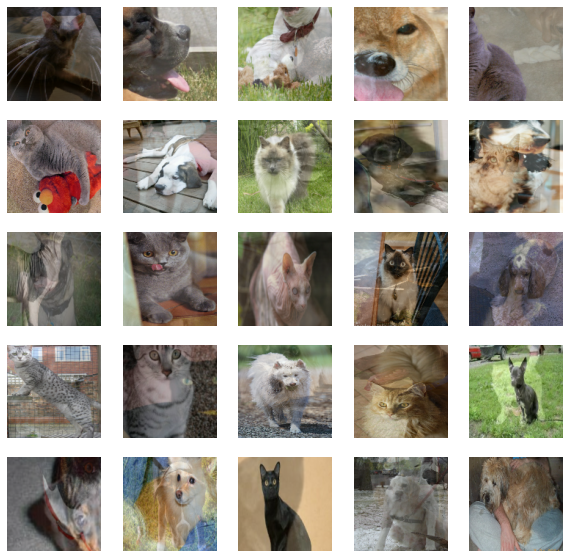

In [12]:
sample_images, _ = next(iter(training_dataset))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images[n].numpy())
    plt.axis("off")
plt.show()

## Distillation utilities

In [13]:
def get_student():
    # References:
    # https://github.com/google-research/big_transfer/blob/master/bit_tf2/train.py#L97-L104
    # https://github.com/google-research/big_transfer/blob/master/bit_tf2/models.py#L273-L278
    model = models.ResnetV2(
        num_units=(3, 4, 6, 3),
        num_outputs=37,
        filters_factor=4,
        name="resnet",
        trainable=True,
        dtype=tf.float32
    )
    return model

model = get_student()
model.build((None, RESIZE, RESIZE, 3))
model.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
root_block (Sequential)      (None, 32, 32, 64)        9408      
_________________________________________________________________
block1 (Sequential)          (None, 32, 32, 256)       214912    
_________________________________________________________________
block2 (Sequential)          (None, 16, 16, 512)       1218048   
_________________________________________________________________
block3 (Sequential)          (None, 8, 8, 1024)        7095296   
_________________________________________________________________
block4 (Sequential)          (None, 4, 4, 2048)        14958592  
_________________________________________________________________
group_norm (GroupNormalizati multiple                  4096      
_________________________________________________________________
re_lu_48 (ReLU)              multiple                  0    

In [14]:
# Last layer does have softmax.
model.layers[-1].get_config()

{'name': 'head/dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 37,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

This is the standard ResNet50 (v2) and is here for experimentation. This differs from the BiT family of ResNets in the following way: they do not use Batch Normalization and instead use Weight Standardization and Group Normalization. 

In [15]:
# def get_resnetv2():
#     resnet_v2 = tf.keras.applications.ResNet50V2(weights=None,
#                                                  input_shape=(RESIZE, RESIZE, 3),
#                                                  classes=37,
#                                                  classifier_activation="linear")
#     return resnet_v2

Here's an expansion of the KL-Divergence loss taken from the paper:

$$
\mathrm{KL}\left(p_{t} \| p_{s}\right)=\sum_{i \in \mathcal{C}}\left[-p_{t, i} \log p_{s, i}+p_{t, i} \log p_{t, i}\right]
$$

In [16]:
# Reference:
# https://www.tutorialexample.com/implement-kl-divergence-loss-in-tensorflow-tensorflow-tutorial/
def kl_divergence(true_p, q):
    true_prob = tf.nn.softmax(true_p, axis = 1)
    loss_1 = -tf.nn.softmax_cross_entropy_with_logits(logits=true_p, labels=true_prob)
    loss_2 = tf.nn.softmax_cross_entropy_with_logits(logits=q, labels=true_prob)   
    loss = loss_1 + loss_2
    return loss

`true_p` would be the logits from our teacher and `q` would be the student logits. 

In [17]:
# Reference:
# https://keras.io/examples/vision/knowledge_distillation/
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self,
        optimizer,
        metrics,
        distillation_loss_fn,
        temperature=TEMPERATURE,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, _ = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute loss
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions / self.temperature,
                student_predictions / self.temperature
            )
            distillation_loss = tf.nn.compute_average_loss(distillation_loss, 
                                                      global_batch_size=BATCH_SIZE)

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(distillation_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Report progress
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)

        # Calculate the loss
        distillation_loss = self.distillation_loss_fn(
            teacher_predictions / self.temperature,
            student_predictions / self.temperature
        )
        distillation_loss = tf.nn.compute_average_loss(distillation_loss, 
                                                      global_batch_size=BATCH_SIZE)

        # Report progress
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"distillation_loss": distillation_loss}
        )
        return results

## Warm-up Cosine LR schedule

In [18]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

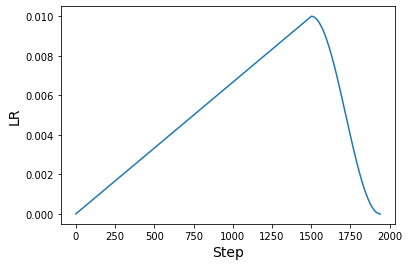

In [19]:
TOTAL_STEPS = int(DATASET_NUM_TRAIN_EXAMPLES / BATCH_SIZE * EPOCHS)
scheduled_lrs = WarmUpCosine(learning_rate_base=INIT_LR,
                             total_steps=TOTAL_STEPS,
                             warmup_learning_rate=0.0,
                             warmup_steps=1500)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

## Training

TPU takes sometime to get initialized and hence the first epoch might take more time. Rest of the epochs should complete within ~5 seconds.

In [20]:
# The teacher model gives 90.93% top-1 accuracy on the test set.
# Authors report 91.03%. 
GCS_PATH_TEACHER = "gs://funmatch-tf/models/T-r101x3-128"

with strategy.scope():
    optimizer = tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, 
                                learning_rate=scheduled_lrs,
                                clipnorm=CLIP_THRESHOLD)
    teacher = tf.keras.models.load_model(GCS_PATH_TEACHER)
    student = get_student()
    student.build((None, RESIZE, RESIZE, 3))
    
    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn=kl_divergence,
        temperature=TEMPERATURE)
    
history = distiller.fit(
    training_dataset,
    steps_per_epoch=int(np.ceil(DATASET_NUM_TRAIN_EXAMPLES / BATCH_SIZE)),
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/300
7/7 [==============================] - 145s 5s/step - distillation_loss: 0.1574 - val_sparse_categorical_accuracy: 0.0326 - val_distillation_loss: 0.1303
Epoch 2/300
7/7 [==============================] - 3s 427ms/step - distillation_loss: 0.1369 - val_sparse_categorical_accuracy: 0.0217 - val_distillation_loss: 0.1379
Epoch 3/300
7/7 [==============================] - 3s 412ms/step - distillation_loss: 0.1362 - val_sparse_categorical_accuracy: 0.0217 - val_distillation_loss: 0.1404
Epoch 4/300
7/7 [==============================] - 3s 413ms/step - distillation_loss: 0.1293 - val_sparse_categorical_accuracy: 0.0217 - val_distillation_loss: 0.1360
Epoch 5/300
7/7 [==============================] - 3s 426ms/step - distillation_loss: 0.1145 - val_sparse_categorical_accuracy: 0.0408 - val_distillation_loss: 0.1373
Epoch 6/300
7/7 [==============================] - 3s 427ms/step - distillation_loss: 0.1244 - val_sparse_categorical_accuracy: 0.0462 - val_distillation_loss: 0.1401

The training accuracy does not matter here. 

## Evaluation

In [21]:
student = distiller.student

with strategy.scope():
    student.compile(metrics=["accuracy"])
    _, top1_accuracy = student.evaluate(test_dataset)
    
print(f"Top-1 accuracy on the test set: {round(top1_accuracy * 100, 2)}%")

8/8 [==============================] - 23s 1s/step - loss: 0.0000e+00 - accuracy: 0.8107
Top-1 accuracy on the test set: 81.3%


Score reported in the paper for this setting is 82.75% which is close to what we got. Here are some differences to note:

* The authors make use of a bigger teacher model (ResNet152x2) which is slighly better (91.03% accurate) than what we used. 
* The `mixup()` variant we are using would produce a pair of duplicate images if the number of images is even. Now, for 8 workers it would become 8 pairs. This may have led to the reduced performance. Nevertheless, I found the `mixup()` implementation to be an easier read (a part of it was referred from [here](https://github.com/google-research/big_transfer/blob/master/input_pipeline_tf2_or_jax.py). Also, thanks to Lucas Beyer for pointing this out.

In [23]:
student.save("gs://funmatch-tf/models/S-r50x1-128-300")

## Acknowledgements

Huge thanks to [Lucas Beyer](https://scholar.google.com/citations?user=p2gwhK4AAAAJ&hl=en) (first author of the paper) for providing suggestions on the initial version of the implementation. 

Thanks to the [ML-GDE program](https://developers.google.com/programs/experts/) for providing GCP credits. 